<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/%E1%84%8B%E1%85%B4%E1%84%85%E1%85%AD%E1%84%8B%E1%85%B5%E1%86%AB%E1%84%80%E1%85%A9%E1%86%BC%E1%84%8C%E1%85%B5%E1%84%82%E1%85%B3%E1%86%BC%E1%84%92%E1%85%A1%E1%86%A8%E1%84%92%E1%85%AC%E1%84%80%E1%85%A1%E1%86%BC%E1%84%8B%E1%85%B4_CNN%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%8C%E1%85%A1%E1%84%85%E1%85%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능학회강의_CNN실습자료
# 개발자를 위한 AI 실습과정
# 2023. 11. 22

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import PIL
import os
from PIL import Image
from tempfile import TemporaryDirectory

!pip install split-folders
import splitfolders
!gdown 1F-2UVD7_a2q13Gv5ns_F2Ytc2N0V8pos
!tar -zxf MedNIST.tar.gz
cudnn.benchmark = True

Downloading...
From: https://drive.google.com/uc?id=1F-2UVD7_a2q13Gv5ns_F2Ytc2N0V8pos
To: /content/MedNIST.tar.gz
100% 61.8M/61.8M [00:01<00:00, 32.5MB/s]


In [ ]:
root_dir = os.path.join("MedNIST") # mednist 데이터셋이 있는 경로

In [ ]:
class_names = sorted(x for x in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, x)))  #  클래스 이름 리스트
num_class = len(class_names) # 클래스 개수
image_files = [ # 각 클래스별 이미지 경로 리스트
    [os.path.join(root_dir, class_names[i], x) for x in os.listdir(os.path.join(root_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)] # 각 클래스별 이미지 개수
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i]) # 이미지 경로 리스트
    image_class.extend([i] * num_each[i]) # 이미지 라벨 리스트
num_total = len(image_class)   # 전체 이미지 개수
image_width, image_height = PIL.Image.open(image_files_list[0]).size # 이미지 사이즈 확인

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


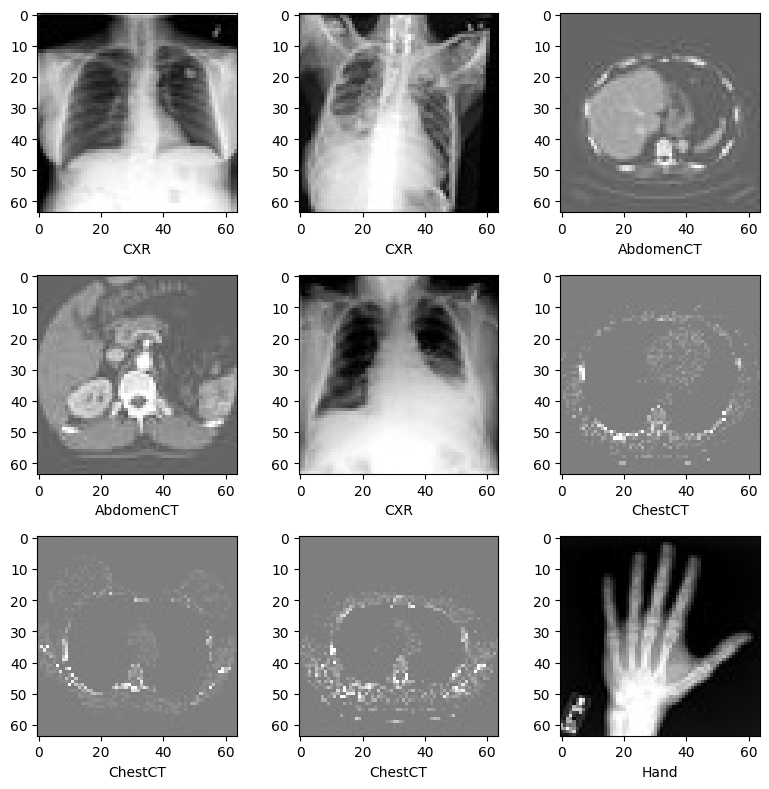

In [ ]:

# 예시 이미지 출력
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
data_dir="data"
# train, val, test 데이터로 분할
splitfolders.fixed(root_dir, data_dir,
    seed=1337, fixed=(1000,100,100),group_prefix=None) # 각 클래스별 1000개씩 train, 100개씩 val, 100개씩 test 데이터로 분할

Copying files: 7200 files [00:02, 2837.61 files/s]


In [ ]:
print(os.listdir(os.path.join(data_dir,"train"))) # train 데이터 확인

['CXR', 'ChestCT', 'BreastMRI', 'Hand', 'HeadCT', 'AbdomenCT']


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

# 데이터셋에 적용할 변형(transformation) 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 만들기
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
# 데이터로더 만들기
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=300,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']} # 데이터셋 크기
class_names = image_datasets['train'].classes # 클래스 이름

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용 가능 여부에 따라 device 정보 저장

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset_sizes # 데이터셋 크기 확인

{'train': 6000, 'val': 600, 'test': 600}

In [ ]:
model = models.resnet50(pretrained=True).to(device)  # resnet50 모델 불러오기

loss_function = torch.nn.CrossEntropyLoss() # loss function 정의
optimizer = torch.optim.Adam(model.parameters(), 1e-5) # optimizer 정의
max_epochs = 5 # epoch 수 정의

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


In [ ]:




# 모델 학습
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt') # 모델 저장 경로

    torch.save(model.state_dict(), best_model_params_path) # 모델 저장
    best_acc = 0.0

    for epoch in range(max_epochs): # epoch 반복
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_function(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(f"train_loss: {loss.item():.4f}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    # best val accuracy 값 출력
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

Epoch 1/5
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train_loss: 13.4124
train_loss: 12.8572
train_loss: 11.9812
train_loss: 11.7946
train_loss: 11.3032
train_loss: 10.5434
train_loss: 10.2661
train_loss: 9.6632
train_loss: 9.2567
train_loss: 9.0072
train_loss: 8.6775
train_loss: 7.9176
train_loss: 7.8174
train_loss: 7.0873
train_loss: 7.0133
train_loss: 6.3979
train_loss: 6.1226
train_loss: 5.9931
train_loss: 5.2578
train_loss: 4.9972
train Loss: 8.8684 Acc: 0.0785
train_loss: 5.7900
train_loss: 5.6286
val Loss: 5.7093 Acc: 0.2400

Epoch 2/5
----------
train_loss: 4.1857
train_loss: 3.7882
train_loss: 3.7459
train_loss: 3.1820
train_loss: 3.0672
train_loss: 2.7976
train_loss: 2.6042
train_loss: 2.4452
train_loss: 2.3419
train_loss: 1.8709
train_loss: 2.1161
train_loss: 1.7512
train_loss: 1.8036
train_loss: 1.6125
train_loss: 1.5566
train_loss: 1.4333
train_loss: 1.2228
train_loss: 1.1371
train_loss: 1.1806
train_loss: 0.9162
train Loss: 2.2379 Acc: 0.6155
train_loss: 3.1307
train_loss: 2.7490
val Loss: 2.9398 Acc: 0.5167

Epoch 3/5
----

In [ ]:
model.eval() # 모델 평가 모드로 전환
y_true = [] # 정답 라벨 리스트
y_pred = [] # 예측 라벨 리스트

In [ ]:

# 모델 평가
with torch.no_grad(): # 평가시에는 gradient 계산을 수행하지 않음
    for i, (inputs, labels) in enumerate(dataloaders["test"]): # test 데이터에 대해 batch 단위로 반복
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs) # 모델 출력
        _, preds = torch.max(outputs, 1) # 모델 출력값 중 가장 큰 값의 인덱스 저장
        print(len(preds) ,end='\r')
        for i in range(len(preds)): # batch 단위로 예측값과 정답값 저장
          y_true.append(labels[i].item()) # 정답 라벨 리스트에 정답값 저장
          y_pred.append(preds[i].item()) # 예측 라벨 리스트에 예측값 저장

In [ ]:
from sklearn.metrics import classification_report

# classification report 출력
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


              precision    recall  f1-score   support

   AbdomenCT     0.9694    0.9500    0.9596       100
   BreastMRI     0.9293    0.9200    0.9246       100
         CXR     0.8286    0.8700    0.8488       100
     ChestCT     0.9159    0.9800    0.9469       100
        Hand     0.7917    0.7600    0.7755       100
      HeadCT     0.9053    0.8600    0.8821       100

    accuracy                         0.8900       600
   macro avg     0.8900    0.8900    0.8896       600
weighted avg     0.8900    0.8900    0.8896       600

